In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import glob
import pandas as pd
import tensorflow as tf

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Visualization of results for regularly updated QNet

Visualize location predicted by QNet that is updated on a regular (daily) basis.

Code to predict locations and return dataframe given files to stored xarray data

In [7]:

def normalize(data):
    data = data/np.max(np.abs(data))
    return data
def check_predictions(data_files, model, pd_dict_name, detection_threshold=0.6):

    '''

    pd = (data_files, model, pd_dict_name, detection_threshold=0.6)

    Runs model prediction for all data_files and returns file names of the detected events,
    list of detections (True/False) and a list of all the filenames.
    Additionally it generates pandas dataframe with information about the prediction for each event.

    Args:
        data_files: list of paths to input data
        model: model used for predictions
        pd_dict_name: name of dictionary to save
        detection_threshold: detection threshold

    Retuns:
        pd: pandas dataframe (also saved to disk)

    '''
    
    distances_old, distances_new = [], []
    true_x_new, true_y_new, true_z_new, pred_x, pred_y, pred_z = [], [], [], [], [], []
    true_x_old, true_y_old, true_z_old = [], [], []
    x_error, y_error, z_error = [], [], []
    snr, magnitude = [], []
    vol, clvd, dc = [], [], []
    file_name = []
    detection = []
    fns = []
    max_val = []
    day = []

    x = np.reshape(np.linspace(5500,8500,128), (128,))
    y = np.reshape(np.linspace(3500,6100,96), (96,))
    z = np.reshape(np.linspace(1400,3600,64), (64,))
    
    for i, fn in enumerate(data_files):

        ds = xr.open_dataset(fn)
        data = ds['data'].values
        dt = 0.002
        t = np.arange(0,1401)*dt
        tn = np.linspace(0,t[-1],1024)
        dtn = tn[1]-tn[0]
        data_new = np.zeros((len(tn),data.shape[1]))
        for i in range(data_new.shape[1]):
            data_new[:,i] = np.interp(tn, t, data[:,i])
        data = data_new
        sx_old = ds.attrs['source_coordinates_new']
        sx_new = ds.attrs['source_coordinates']
        sx_error = ds.attrs['loc_errors']
        
        true_x_new.append(sx_new[0])
        true_y_new.append(sx_new[1])
        true_z_new.append(sx_new[2])
        true_x_old.append(sx_old[0])
        true_y_old.append(sx_old[1])
        true_z_old.append(sx_old[2])
        x_error.append(sx_error[0])
        y_error.append(sx_error[1])
        z_error.append(sx_error[2])
        snr.append(ds.attrs['SNR'])
        magnitude.append(ds.attrs['Magnitude'])
        vol.append(ds.attrs['VOL'])
        clvd.append(ds.attrs['CLVD'])
        dc.append(ds.attrs['DC'])
        file_name.append(fn.split('/')[-1])
        fns.append(fn)
        day.append(ds.attrs['day'])
        
        data = normalize(data)
        data = np.reshape(data, (1, data.shape[0], data.shape[1],1))
        prediction = model.predict(data)[0,:]
    
        maxIdx = np.unravel_index(np.argmax(prediction), prediction.shape)
        xp = x[maxIdx[0]]
        yp = y[maxIdx[1]]
        zp = z[maxIdx[2]]
        
        pred_x.append(xp)
        pred_y.append(yp)
        pred_z.append(zp)
        max_val.append(np.max(prediction))
        
        dist_old = np.sqrt((sx_old[0]-x[maxIdx[0]])**2+(sx_old[1]-y[maxIdx[1]])**2+(sx_old[2]-z[maxIdx[2]])**2)
        dist_new = np.sqrt((sx_new[0]-x[maxIdx[0]])**2+(sx_new[1]-y[maxIdx[1]])**2+(sx_new[2]-z[maxIdx[2]])**2)
        
        distances_old.append(dist_old)
        distances_new.append(dist_new)

        if np.max(prediction) >= detection_threshold:
            detection.append(True)
        else:
            detection.append(False)
            
    df = pd.DataFrame(
        {
            'file': file_name,
            'detection': detection,
            'distances_old': distances_old,
            'distances_new': distances_new,
            'new_true_x': true_x_new,
            'new_true_y': true_y_new,
            'new_true_z': true_z_new,
            'old_true_x': true_x_old,
            'old_true_y': true_y_old,
            'old_true_z': true_z_old,
            'pred_x': pred_x,
            'pred_y': pred_y,
            'pred_z': pred_z,
            'max_val': max_val,
            'x_error': x_error,
            'y_error': y_error,
            'z_error': z_error,
            'SNR': snr,
            'Magnitude': magnitude,
            'Volume': vol,
            'DC': dc,
            'CLVD': clvd,
            'filenames': fns,
            'day': day
        })
    
    df.to_csv(pd_dict_name)

    n_detections = sum(bool(x) for x in detection)
    print("Number of events detected: {}".format(n_detections))

    return df

Path to data files

In [8]:
PATH_TO_DATA = "drive/My Drive/cnn_gpu/texas_dataset"
train_fns = glob.glob(PATH_TO_DATA + '/train*.nc')
val_fns = glob.glob(PATH_TO_DATA + '/val*.nc')
test_fns = glob.glob(PATH_TO_DATA + '/test*.nc')

In [18]:
len(test_fns)

248

Apply firsr TL model (trained on 4 days of field data) to day 5

In [15]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_coef_gaussian(y_true, y_pred, smooth=1):
    y_true = tf.dtypes.cast(y_true>0.1, tf.int32)
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_pred = tf.dtypes.cast(y_pred>0.1, tf.int32)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

path_model = 'drive/My Drive/Texas_TL/TL_models/TL_TFR_all_temp/QNet_update_84.h5'#regular_updating/QNet_0.h5'
model = tf.keras.models.load_model(
        path_model,
        custom_objects={
            'LeakyReLU':tf.keras.layers.LeakyReLU, 'ReLU':tf.keras.layers.ReLU,
            'dice_coef_gaussian': dice_coef_gaussian, 'dice_coef': dice_coef,
        })
    
#F1_tmp, F1_binary_tmp, hypo_dist_tmp, epi_dist_tmp, depth_dist_tmp, max_val_tmp = run_validations(val_fns, model, days=(0, 30))
df_val = check_predictions(val_fns, model, 'tmp.csv')
df_test = check_predictions(test_fns, model, 'tmp.csv')
df_train = check_predictions(train_fns, model, 'tmp.csv')

Number of events detected: 240
Number of events detected: 237
Number of events detected: 729


Load model and predict on next day of data. Append results to dataframe

In [ ]:
days_list = [21,22,23,24]

for i, day in enumerate(days_list):
  path_model = 'drive/My Drive/Texas_TL/TL_models/TL_TFR_regular_updating/QNet_updated_{}.h5'.format(i+1)
  model = tf.keras.models.load_model(
      path_model,
      custom_objects={
          'LeakyReLU':tf.keras.layers.LeakyReLU, 'ReLU':tf.keras.layers.ReLU,
          'dice_coef_gaussian': dice_coef_gaussian, 'dice_coef': dice_coef,
      }
  )

  df_val = check_predictions(val_fns, model, 'tmp.csv')
  df_test = check_predictions(test_fns, model, 'tmp.csv')
  df_train = check_predictions(train_fns, model, 'tmp.csv')

  df_tmp = df_train.append(df_val)
  df_tmp = df_tmp.append(df_test)
  df_tmp = df_tmp[df_tmp['day']==day]

  if i == 0:
    df_comb = df_tmp
  else:
    df_comb = df_comb.append(df_tmp)

In [ ]:
df_comb

Plot predicted locations and locations given in the catalog

In [10]:
print(df_train.shape, df_test.shape, df_val.shape)

(747, 24) (248, 24) (249, 24)


In [16]:
df_comb = df_train.append(df_val)
df_comb = df_comb.append(df_test)

print(df_comb.shape)

(1244, 24)


(198, 24)
(90, 24)


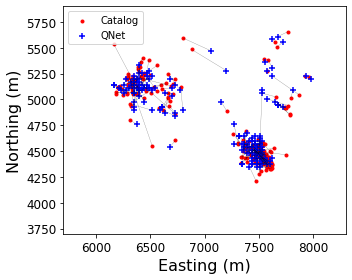

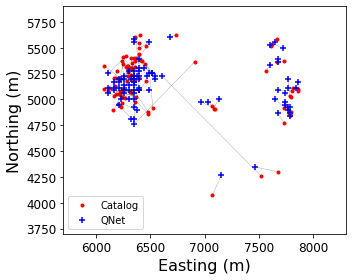

In [53]:
for d in range(23,25):

  df_test2 = df2[df2['max_val']>0.7]
  df_test2 = df_test2[df_test2['day']==d]

  print(df_test2.shape)


  xc = df_test2['new_true_x'].values
  xp = df_test2['pred_x'].values
  yc = df_test2['new_true_y'].values
  yp = df_test2['pred_y'].values
  zc = df_test2['new_true_z'].values-400
  zp = df_test2['pred_z'].values-400
  
  linesxy = []
  linesxz = []
  for i, j in enumerate(xc):
    tup1 = (xc[i], yc[i])
    tup2 = (xp[i], yp[i])
    tup3 = (xc[i], zc[i])
    tup4 = (xp[i], zp[i])
    linesxy.append(list([tup1, tup2]))
    linesxz.append(list([tup3, tup4]))

  fig, ax = plt.subplots(figsize=(5,4))

  ax.scatter(df_test2['new_true_x'], df_test2['new_true_y'], color='r', marker='.')
  ax.scatter(df_test2['pred_x'], df_test2['pred_y'], color='b', marker='+')
  ax.set_xlabel('Easting (m)', fontsize=16)
  ax.set_ylabel('Northing (m)', fontsize=16)
  ax.set_xlim([5700, 8300])
  ax.set_ylim([3700, 5900])
  lc = LineCollection(linesxy, color='k', alpha=0.5, linewidths=.3)
  ax.add_collection(lc)
  ax.legend(['Catalog', 'QNet'])
  ax.tick_params(labelsize=12)
  
  plt.tight_layout()
  
  #plt.savefig('drive/My Drive/Texas_TL/Figures/Figures_day/epi_QNet1_{}.pdf'.format(d))
  

Apply QNet updated once and QNet updated twice on all the data

In [20]:
path_model = 'drive/My Drive/Texas_TL/TL_models/TL_TFR_regular_updating/QNet_0.h5'
QNet1 = tf.keras.models.load_model(
        path_model,
        custom_objects={
            'LeakyReLU':tf.keras.layers.LeakyReLU, 'ReLU':tf.keras.layers.ReLU,
            'dice_coef_gaussian': dice_coef_gaussian, 'dice_coef': dice_coef,
        })
    
#F1_tmp, F1_binary_tmp, hypo_dist_tmp, epi_dist_tmp, depth_dist_tmp, max_val_tmp = run_validations(val_fns, model, days=(0, 30))
df_val = check_predictions(val_fns, QNet1, 'tmp.csv')
df_test = check_predictions(test_fns, QNet1, 'tmp.csv')
df_train = check_predictions(train_fns, QNet1, 'tmp.csv')
df1 = df_val.append(df_test)
df1 = df1.append(df_train)

path_model = 'drive/My Drive/Texas_TL/TL_models/TL_TFR_all_temp/QNet_update_84.h5'
QNet2 = tf.keras.models.load_model(
        path_model,
        custom_objects={
            'LeakyReLU':tf.keras.layers.LeakyReLU, 'ReLU':tf.keras.layers.ReLU,
            'dice_coef_gaussian': dice_coef_gaussian, 'dice_coef': dice_coef,
        })
    
#F1_tmp, F1_binary_tmp, hypo_dist_tmp, epi_dist_tmp, depth_dist_tmp, max_val_tmp = run_validations(val_fns, model, days=(0, 30))
df_val = check_predictions(val_fns, QNet2, 'tmp.csv')
df_test = check_predictions(test_fns, QNet2, 'tmp.csv')
df_train = check_predictions(train_fns, QNet2, 'tmp.csv')

df2 = df_val.append(df_test)
df2 = df2.append(df_train)

Number of events detected: 233
Number of events detected: 228
Number of events detected: 703
Number of events detected: 240
Number of events detected: 237
Number of events detected: 729


Keep events recorded on last two days and those that passed the threshold of 0.7 (maximum value in predicted output)

In [21]:
df1_sub = df1[df1['day']>22]
df1_sub = df1_sub[df1_sub['max_val']>0.7]

df2_sub = df2[df2['day']>22]
df2_sub = df2_sub[df2_sub['max_val']>0.7]

Find events that both dataframes share in common a view statistics

In [42]:
df2_in_df1 = df2_sub[df2_sub['filenames'].isin(df1_sub['filenames'])]

In [54]:
df1_sub2 = df1_sub[df1_sub['filenames'].isin(df2_in_df1['filenames'])]

In [55]:
df2_in_df1.describe()

,distances_old,distances_new,new_true_x,new_true_y,new_true_z,old_true_x,old_true_y,old_true_z,pred_x,pred_y,pred_z,max_val,x_error,y_error,z_error,SNR,Magnitude,Volume,DC,CLVD,day
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000
mean,225.692012,209.042457,7059.121240,4847.476634,2423.358847,7054.005495,4851.165645,2405.834003,7044.919090,4858.939080,2442.807149,0.911083,94.367730,97.907681,77.929891,0.781463,0.036874,-0.094020,0.522886,-0.116540,23.295276
std,131.872715,141.438186,607.251068,378.021029,190.895208,616.212961,369.562829,181.892403,575.192339,345.747667,94.076069,0.033016,137.242678,139.873438,93.994132,0.223954,0.272888,0.179770,0.202033,0.336710,0.457067
min,12.683673,8.497890,6071.175530,4071.598786,1905.167360,5910.364104,3999.828361,1885.194125,6114.173228,4266.315789,2098.412698,0.716572,5.358816,2.988547,0.000480,0.402601,-0.474582,-0.434596,0.063162,-0.798070,23.000000
25%,137.743871,113.472626,6366.645390,4465.439855,2329.943796,6373.076632,4482.228928,2324.484819,6397.637795,4512.631579,2377.777778,0.902502,22.020135,21.338734,20.571133,0.641590,-0.133987,-0.226900,0.392315,-0.366305,23.000000
50%,195.602058,169.452150,7385.607549,4914.184029,2483.312523,7411.796314,4902.317688,2415.380076,7389.763780,4936.842105,2482.539683,0.916242,40.628988,41.328506,44.990666,0.758282,-0.015259,-0.122785,0.521411,-0.161057,23.000000
75%,293.331193,273.369799,7573.836548,5139.358683,2525.172790,7590.282205,5164.876340,2505.755389,7507.874016,5142.105263,2517.460317,0.930643,80.389507,95.007631,85.224139,0.871422,0.145906,0.021644,0.676354,0.117353,24.000000
max,1058.467930,936.483173,7966.742188,5654.398438,3232.750455,8084.727563,5679.354083,3165.272667,7980.314961,5607.368421,2761.904762,0.961148,750.475940,823.330033,504.692866,2.000346,1.518246,0.483611,0.957560,0.761724,24.000000


In [56]:
df1_sub2.describe()

,distances_old,distances_new,new_true_x,new_true_y,new_true_z,old_true_x,old_true_y,old_true_z,pred_x,pred_y,pred_z,max_val,x_error,y_error,z_error,SNR,Magnitude,Volume,DC,CLVD,day
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000
mean,226.387987,228.956922,7059.121240,4847.476634,2423.358847,7054.005495,4851.165645,2405.834003,7038.316077,4808.296726,2407.336583,0.870621,94.367730,97.907681,77.929891,0.781463,0.036874,-0.094020,0.522886,-0.116540,23.295276
std,123.509245,135.349998,607.251068,378.021029,190.895208,616.212961,369.562829,181.892403,572.078356,360.259655,113.038843,0.058720,137.242678,139.873438,93.994132,0.223954,0.272888,0.179770,0.202033,0.336710,0.457067
min,25.349460,16.730359,6071.175530,4071.598786,1905.167360,5910.364104,3999.828361,1885.194125,6043.307087,4156.842105,2098.412698,0.704339,5.358816,2.988547,0.000480,0.402601,-0.474582,-0.434596,0.063162,-0.798070,23.000000
25%,139.310606,135.774270,6366.645390,4465.439855,2329.943796,6373.076632,4482.228928,2324.484819,6397.637795,4430.526316,2307.936508,0.841872,22.020135,21.338734,20.571133,0.641590,-0.133987,-0.226900,0.392315,-0.366305,23.000000
50%,205.638848,208.515663,7385.607549,4914.184029,2483.312523,7411.796314,4902.317688,2415.380076,7366.141732,4895.789474,2377.777778,0.896541,40.628988,41.328506,44.990666,0.758282,-0.015259,-0.122785,0.521411,-0.161057,23.000000
75%,288.513293,280.916294,7573.836548,5139.358683,2525.172790,7590.282205,5164.876340,2505.755389,7507.874016,5087.368421,2517.460317,0.909434,80.389507,95.007631,85.224139,0.871422,0.145906,0.021644,0.676354,0.117353,24.000000
max,792.841788,887.052228,7966.742188,5654.398438,3232.750455,8084.727563,5679.354083,3165.272667,7956.692913,5607.368421,2657.142857,0.946664,750.475940,823.330033,504.692866,2.000346,1.518246,0.483611,0.957560,0.761724,24.000000
